In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import glob
import os
import zipfile
import cv2

from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
train_data_path = './data/train/'
test_data_path = './data/test/'

base_dir = '.'

batch_size = 64
epochs = 20

In [86]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('./data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('./data')

In [3]:
train_list = glob.glob(os.path.join(train_data_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_data_path, '*.jpg'))

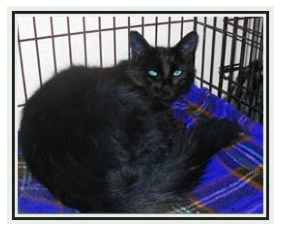

In [4]:
img = cv2.imread(train_list[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
train_list, val_list = train_test_split(train_list, test_size=0.1)

In [6]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((64,64)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize((64,64)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)
    
class DogVsCatDataset(torch.utils.data.Dataset):
    
    def __init__(self, files, transform=None, phase='train'):
        self.files = files
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        
        img_path = self.files[idx]
        img = Image.open(img_path)
        transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return transformed, label

In [7]:
#data_mean = np.array([0.48831832, 0.45507723, 0.41695])
#data_std = np.array([0.25164324, 0.24494624, 0.24766314])


data_mean = (0.485, 0.456, 0.406)
data_std = (0.229, 0.224, 0.225)

In [8]:
train_dataset = DogVsCatDataset(train_list, transform=ImageTransform(64, data_mean, data_std), phase='train')
val_dataset = DogVsCatDataset(val_list, transform=ImageTransform(64, data_mean, data_std), phase='val')

In [9]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4, pin_memory=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=64, num_workers=4, pin_memory=True)

In [10]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
simplenet = SimpleNet()

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

simplenet = simplenet.to(device)

In [13]:
optimizer = optim.Adam(simplenet.parameters())

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    simplenet.train()
    for data, label in train_data_loader:
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = simplenet(data)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * data.size(0)
    training_loss /= len(train_data_loader.dataset)
        
    simplenet.eval()
    num_correct = 0 
    num_examples = 0
    for data, label in val_data_loader:
        data = data.to(device)
        label = label.to(device)
        output = simplenet(data)
        loss = loss_fn(output, label) 
        valid_loss += loss.data.item() * data.size(0)
        correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], label)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    valid_loss /= len(val_data_loader.dataset)

    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

Epoch: 0, Training Loss: 0.69, Validation Loss: 0.65, accuracy = 0.63
Epoch: 1, Training Loss: 0.62, Validation Loss: 0.64, accuracy = 0.63
Epoch: 2, Training Loss: 0.59, Validation Loss: 0.63, accuracy = 0.64
